# **Clasificación de tweets misóginos y no misóginos**

**Equipo:**

Fernando Barajas Ramírez 2085375​

Leobardo García Reyes 1616825

David Eduardo Gallardo Fernández 0931556

# Librerías

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install geopandas
!pip install vaderSentiment
!pip install pygal_maps_world

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 6.3 MB 47.9 MB/s 
     |████████████████████████████████| 16.7 MB 307 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 5.0 MB/s 
     |████████████████████████████████| 129 kB 59.4 MB/s 
  Created wheel for pygal-maps-world: filename=pygal_maps_world-1.0.2-py3-none-any.whl size=278561 sha256=dab7baa8d17dd61678c1b42eff2dc5bbeecbf8b4f7f4a6dfd4808d8780478351
  Stored in directory: /root/.cache/pip/wheels/54/e6/11/5be0d3206bdc0ea8f0fcf1fe32661d7e614863c8b6a22655ae
Successfully built pygal-maps-world


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display
import pygal

from time import time
import re, string, unicodedata
from unicodedata import normalize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn

import sklearn
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_recall_curve, recall_score, precision_score

In [4]:
nltk.download('punkt') # Descargar tokenizar
nltk.download('stopwords') # Descargar stopwords
nltk.download('wordnet') # Descargar lematización
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

# Lectura y manipulación de la base de datos

In [5]:
# Lectura de base de datos
base = pd.read_csv('/content/drive/MyDrive/Mini-proyecto Texto/tweets_mnm-varw.csv')
base.head(4)

,ID,Tweet,Creado_tweet,Locacion_usuario,Seguidores_usuario,Amigos_usuario,Favoritos_usuario,Descripcion_usuario,Verificado_usuario,Idioma,Tipo
0,1206646560618094594,@LaFallaras Payasa háztelo mirar,2019-12-16 18:45:33,NaN,261,600,57626,Por España y el que quiera defenderla honrado ...,False,es,misogino
1,1206646560618094594,@LaFallaras Payasa háztelo mirar,2019-12-16 18:45:33,NaN,261,600,57626,Por España y el que quiera defenderla honrado ...,False,es,misogino
2,1205621070457376768,@LaFallaras @populares @CiudadanosCs Eres paté...,2019-12-13 22:50:37,"Azuqueca de Henares, España",5369,1486,4812,I love spanking bad girls of all ages (+ 18) S...,False,es,misogino
3,1205621070457376768,@LaFallaras @populares @CiudadanosCs Eres paté...,2019-12-13 22:50:37,"Azuqueca de Henares, España",5369,1486,4812,I love spanking bad girls of all ages (+ 18) S...,False,es,misogino


In [6]:
# Información de las variables
base.dtypes

ID                      int64
Tweet                  object
Creado_tweet           object
Locacion_usuario       object
Seguidores_usuario      int64
Amigos_usuario          int64
Favoritos_usuario       int64
Descripcion_usuario    object
Verificado_usuario       bool
Idioma                 object
Tipo                   object
dtype: object

In [7]:
# Conteo de tipos de tweets
base.groupby(['Tipo'])['Tipo'].count()

Tipo
misogino       2599
no_misogino    2910
Name: Tipo, dtype: int64

In [8]:
# Dimensión de los datos y nombre de columnas
print('Dimensiones: {}'.format(base.shape))
print('\n')
print(base.columns)

Dimensiones: (5509, 11)


Index(['ID', 'Tweet', 'Creado_tweet', 'Locacion_usuario', 'Seguidores_usuario',
       'Amigos_usuario', 'Favoritos_usuario', 'Descripcion_usuario',
       'Verificado_usuario', 'Idioma', 'Tipo'],
      dtype='object')


In [9]:
# Quitar IDs duplicados
base = base.drop_duplicates(base.columns[~base.columns.isin(['ID'])],
                                keep = 'first')
base = base.reset_index(drop=True)

In [10]:
# Filtrar solo los tweets en Idioma "es"
base = base[(base.Idioma == "es")]

In [11]:
base = base.sample(frac = 1).reset_index(drop = True)
base.head(4)

,ID,Tweet,Creado_tweet,Locacion_usuario,Seguidores_usuario,Amigos_usuario,Favoritos_usuario,Descripcion_usuario,Verificado_usuario,Idioma,Tipo
0,1211411222731599875,@susanadiaz @psoedeandalucia Estás loca y toda...,2019-12-29 22:18:37,NaN,392,721,19996,Three Little Brids,False,es,misogino
1,1205033613793931266,@monasterioR @julia_otero Religión quereis imp...,2019-12-12 07:56:16,"Río de Janeiro, Brasil",397,490,9733,"Un poco cabron, pero buena peña 🏴‍☠️🗿",False,es,misogino
2,1213771750758109184,"@InesArrimadas demostrando su poco nivel, una ...",2020-01-05 10:38:30,"Berlín, Alemania",6130,6531,23873,Scratch here ▒▒▒▒▒▒▒▒ to unveil my secret bio ...,False,es,misogino
3,1205482413792645120,"@GretaThunberg A tambien eres apolitica, como ...",2019-12-13 13:39:38,NaN,15,119,1214,NaN,False,es,misogino


In [12]:
# Formato a la columna de Creado_tweet
base['Creado_tweet'] = pd.to_datetime(base['Creado_tweet'], format='%Y-%m-%d')

In [13]:
# Agregar columna Verificado para saber si un usuario es verificado o no
base['Verificado'] = base['Verificado_usuario'].apply(lambda x: 'Si' if x==True else 'No')

In [14]:
# Dimensión de los datos y nombre de columnas
print('Dimensiones: {}'.format(base.shape))
print('\n')
print(base.columns)

Dimensiones: (4032, 12)


Index(['ID', 'Tweet', 'Creado_tweet', 'Locacion_usuario', 'Seguidores_usuario',
       'Amigos_usuario', 'Favoritos_usuario', 'Descripcion_usuario',
       'Verificado_usuario', 'Idioma', 'Tipo', 'Verificado'],
      dtype='object')


In [15]:
# Conteo final por tipo de tweet
base.groupby(['Tipo'])['Tipo'].count()

Tipo
misogino       1753
no_misogino    2279
Name: Tipo, dtype: int64

# Limpieza de texto

In [16]:
# Selección de la columna que contine los tweets y la columna de tipo del tweet al que pertenece
TText = pd.DataFrame({'Texto': base['Tweet'], 'Tipo': base['Tipo']})
TText.head(3)

,Texto,Tipo
0,@susanadiaz @psoedeandalucia Estás loca y toda...,misogino
1,@monasterioR @julia_otero Religión quereis imp...,misogino
2,"@InesArrimadas demostrando su poco nivel, una ...",misogino


In [17]:
# Función para limpiar texto
def Limpiar_texto(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Eliminación de usuarios
    nuevo_texto = re.sub('@[\w\-]+', ' ', nuevo_texto)

    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)

    # Eliminación de texto en paréntesis
    nuevo_texto = re.sub('([\(\[]).*?([\)\]])', '\g<1>\g<2>', nuevo_texto)

    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    nuevo_texto = re.sub(r'[^\w\s]', ' ', nuevo_texto)

    # Eliminación de números
    nuevo_texto = re.sub(r'[0-9]+', ' ', nuevo_texto)

    # Eliminación de acentos
    #nuevo_texto = re.sub(r'([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+', r'\1',
    #                     normalize('NFD', nuevo_texto), 0, re.I)
    a,b = 'áéíóúÁÉÍÓÚ','aeiouAEIOU'
    trans = str.maketrans(a,b)
    nuevo_texto = nuevo_texto.translate(trans)
    
    # Eliminación de emojis
    emoj = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002500-\U00002BEF'  # chinese char
        u'\U00002702-\U000027B0'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        u'\U0001f926-\U0001f937'
        u'\U00010000-\U0010ffff'
        u'\u2640-\u2642' 
        u'\u2600-\u2B55'
        u'\u200d'
        u'\u23cf'
        u'\u23e9'
        u'\u231a'
        u'\ufe0f'  # dingbats
        u'\u3030'
                      ']+', re.UNICODE)
    nuevo_texto = re.sub(emoj, ' ', nuevo_texto)

    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub('\\s+', ' ', nuevo_texto)
    
    return(nuevo_texto)

In [18]:
# Aplicar la función de limpiza de texto en la columna de texto
TText['Texto_Limpio'] = TText['Texto'].apply(lambda x: Limpiar_texto(x))
TText[['Texto', 'Tipo', 'Texto_Limpio']].head(3)

,Texto,Tipo,Texto_Limpio
0,@susanadiaz @psoedeandalucia Estás loca y toda...,misogino,estas loca y todavia no te has dado cuenta ha...
1,@monasterioR @julia_otero Religión quereis imp...,misogino,religion quereis imponer vosotr con la puta i...
2,"@InesArrimadas demostrando su poco nivel, una ...",misogino,demostrando su poco nivel una vez mas patetic...


## Stopwords

In [19]:
# Stopwords en español
sw = stopwords.words('spanish')

# Nuevas stopwords
nuevas_sw = ['años', 'si', 'va', 'así', 'ver', 'vez', 'ser', 'do', 'dice', 'hace', 'toda', 'pues', 'da', 'mas',
             'tan', 'hacer', 'decir', 'an', 'ma', 'asi', 'da', 'año', 'años', 'año', 'años', 'estan', 'va',
             'mas', 'cada', 'os', 'ensen', 'ar', 'espan', 'puede', 'nin', 'sen', 'pue', 'ja', 'jajaja', 'demas']

sw.extend(nuevas_sw)

print(sw)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [20]:
# Diccionario de etiquetado POS
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

# Función que etiqueta cada palabra con verbo, sustantivo, adjetivo, adverbio
# También remueve las stopwords
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in sw:
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return(newlist)

TText['Texto_Pos'] = TText['Texto_Limpio'].apply(token_stop_pos)
TText.head(3)

,Texto,Tipo,Texto_Limpio,Texto_Pos
0,@susanadiaz @psoedeandalucia Estás loca y toda...,misogino,estas loca y todavia no te has dado cuenta ha...,"[(loca, v), (todavia, n), (dado, v), (cuenta, ..."
1,@monasterioR @julia_otero Religión quereis imp...,misogino,religion quereis imponer vosotr con la puta i...,"[(religion, n), (quereis, n), (imponer, n), (v..."
2,"@InesArrimadas demostrando su poco nivel, una ...",misogino,demostrando su poco nivel una vez mas patetic...,"[(demostrando, n), (nivel, a), (patetica, n), ..."


## Lematización

In [21]:
# Método Lematizar
wordnet_lemmatizer = WordNetLemmatizer()

# Función para lematizar cada palabra
def lemmatize(pos_data):
    lemma_rew = ' '
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + ' ' + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + ' ' + lemma
    return(lemma_rew)
    
TText['Lema'] = TText['Texto_Pos'].apply(lemmatize)
TText.head(2)

,Texto,Tipo,Texto_Limpio,Texto_Pos,Lema
0,@susanadiaz @psoedeandalucia Estás loca y toda...,misogino,estas loca y todavia no te has dado cuenta ha...,"[(loca, v), (todavia, n), (dado, v), (cuenta, ...",loca todavia dado cuenta tener poca vergüenz...
1,@monasterioR @julia_otero Religión quereis imp...,misogino,religion quereis imponer vosotr con la puta i...,"[(religion, n), (quereis, n), (imponer, n), (v...",religion quereis imponer vosotr puta iglesia...


## Selección de palabras mayores a 1 carácter

In [22]:
# Función para elegir las palabras mayores a 1 carácter
def mayores(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')

    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    return(nuevo_texto)

TText['Mayores'] = TText['Lema'].apply(mayores)
TText.head(2)

,Texto,Tipo,Texto_Limpio,Texto_Pos,Lema,Mayores
0,@susanadiaz @psoedeandalucia Estás loca y toda...,misogino,estas loca y todavia no te has dado cuenta ha...,"[(loca, v), (todavia, n), (dado, v), (cuenta, ...",loca todavia dado cuenta tener poca vergüenz...,"[loca, todavia, dado, cuenta, tener, poca, ver..."
1,@monasterioR @julia_otero Religión quereis imp...,misogino,religion quereis imponer vosotr con la puta i...,"[(religion, n), (quereis, n), (imponer, n), (v...",religion quereis imponer vosotr puta iglesia...,"[religion, quereis, imponer, vosotr, puta, igl..."


In [23]:
# Función para juntar cada tweet en un solo texto
def lema_mayores(texto):
    juntar = ' '
    for word in texto:
        juntar = juntar + ' ' + word
    return juntar

TText['Lema_Mayores'] = TText['Mayores'].apply(lema_mayores)
TText.head(2)

,Texto,Tipo,Texto_Limpio,Texto_Pos,Lema,Mayores,Lema_Mayores
0,@susanadiaz @psoedeandalucia Estás loca y toda...,misogino,estas loca y todavia no te has dado cuenta ha...,"[(loca, v), (todavia, n), (dado, v), (cuenta, ...",loca todavia dado cuenta tener poca vergüenz...,"[loca, todavia, dado, cuenta, tener, poca, ver...",loca todavia dado cuenta tener poca vergüenz...
1,@monasterioR @julia_otero Religión quereis imp...,misogino,religion quereis imponer vosotr con la puta i...,"[(religion, n), (quereis, n), (imponer, n), (v...",religion quereis imponer vosotr puta iglesia...,"[religion, quereis, imponer, vosotr, puta, igl...",religion quereis imponer vosotr puta iglesia...


In [24]:
# Selección de la columna que contiene los tweets originales, la columna del tipo de tweet
# al que pertenece y la columna con los tweets limpios
Texto_final = TText.loc[:, ['Texto', 'Tipo', 'Lema_Mayores']]
Texto_final.head(2)

,Texto,Tipo,Lema_Mayores
0,@susanadiaz @psoedeandalucia Estás loca y toda...,misogino,loca todavia dado cuenta tener poca vergüenz...
1,@monasterioR @julia_otero Religión quereis imp...,misogino,religion quereis imponer vosotr puta iglesia...


In [25]:
# Codificar el tipo de tweet, donde no_misogino sea 0 y misogino sea 1 
#Texto_final['Categoria_ID'] = Texto_final['Tipo'].factorize()[0]
Texto_final['Categoria_ID'] = Texto_final['Tipo'].apply(lambda x: 1 if x=='misogino' else 0)
Categoria_ID_datos = Texto_final[['Tipo', 'Categoria_ID']].drop_duplicates().sort_values('Categoria_ID')
Categoria_a_ID = dict(Categoria_ID_datos.values)
ID_a_Categoria = dict(Categoria_ID_datos[['Categoria_ID', 'Tipo']].values)
Texto_final.head(3)

,Texto,Tipo,Lema_Mayores,Categoria_ID
0,@susanadiaz @psoedeandalucia Estás loca y toda...,misogino,loca todavia dado cuenta tener poca vergüenz...,1
1,@monasterioR @julia_otero Religión quereis imp...,misogino,religion quereis imponer vosotr puta iglesia...,1
2,"@InesArrimadas demostrando su poco nivel, una ...",misogino,demostrando nivel patetica debatedeinvestidura,1


# Gráficos

In [26]:
# Conteo final por tipo de tweet
Tabla_Conteo = base['Tipo'].value_counts()
Tabla_Conteo

no_misogino    2279
misogino       1753
Name: Tipo, dtype: int64

In [27]:
# Conteo por tipo de tweet y si un usuario es verificado
base.groupby(['Tipo','Verificado']).count()

ID  Tweet  Creado_tweet  Locacion_usuario  \
Tipo        Verificado                                                
misogino    No          1752   1752          1752              1058   
            Si             1      1             1                 0   
no_misogino No          1781   1781          1781              1191   
            Si           498    498           498               382   

                        Seguidores_usuario  Amigos_usuario  Favoritos_usuario  \
Tipo        Verificado                                                          
misogino    No                        1752            1752               1752   
            Si                           1               1                  1   
no_misogino No                        1781            1781               1781   
            Si                         498             498                498   

                        Descripcion_usuario  Verificado_usuario  Idioma  
Tipo        Verificado                                                   
misogino    No                         1376                1752    1752  
            Si                            1                   1       1  
no_misogino No                         1503                1781    1781  
            Si                          495                 498     498

In [28]:
# Conteo de ID por tipo de tweet y si un usuario es verificado
conteo = base.groupby(['Tipo','Verificado'])['ID'].count()
conteo

Tipo         Verificado
misogino     No            1752
             Si               1
no_misogino  No            1781
             Si             498
Name: ID, dtype: int64

## Gráfica de pastel

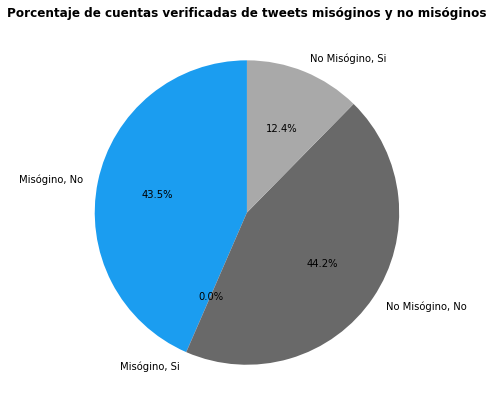

In [29]:
#color = ['purple', 'darkorchid', 'dimgray', 'darkgray']
color = ['#1b9df0', '#004aad', 'dimgray', 'darkgray']
labels = 'Misógino, No', 'Misógino, Si', 'No Misógino, No', 'No Misógino, Si'
conteopastel = base.groupby(['Tipo','Verificado'])['ID'].count()

plt.figure(figsize = (10, 7))
plt.pie(conteopastel, labels = labels, autopct = '%1.1f%%', startangle = 90, colors = color)
plt.title('Porcentaje de cuentas verificadas de tweets misóginos y no misóginos', fontweight = 'bold')
plt.savefig('/content/drive/MyDrive/Mini-proyecto Texto/pastel.jpg')

## Gráfica de barras

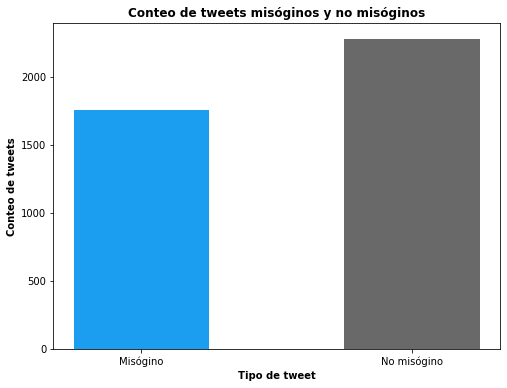

In [30]:
color = ['#1b9df0', 'dimgray']
etiqueta = ['Misógino', 'No misógino']
conteobarra = Texto_final.groupby('Tipo').Lema_Mayores.count()

fig = plt.figure(figsize = (8,6))
plt.bar(etiqueta, conteobarra, color = color,width = 0.5)
plt.title('Conteo de tweets misóginos y no misóginos', fontweight = 'bold')
plt.xlabel('Tipo de tweet', fontweight = 'bold')
plt.ylabel('Conteo de tweets', fontweight = 'bold')
#plt.show()
plt.savefig('/content/drive/MyDrive/Mini-proyecto Texto/barras.jpg')

## Gráfica de tiempo de los tweets

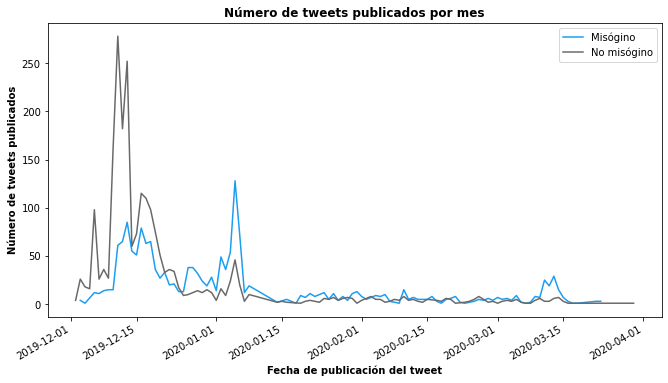

In [31]:
fig, ax = plt.subplots(figsize=(11,6))

for Tipo in base.Tipo.unique():
    df_temp = base[base['Tipo'] == Tipo].copy()
    df_temp['Creado_tweet'] = pd.to_datetime(df_temp['Creado_tweet'].dt.strftime('%Y-%m-%d'))
    df_temp = df_temp.groupby(df_temp['Creado_tweet']).size()
    df_temp.plot(label=Tipo, ax=ax, color={"misogino": '#1b9df0', "no_misogino": 'dimgray'})

plt.title('Número de tweets publicados por mes', fontweight = 'bold')
plt.xlabel('Fecha de publicación del tweet', fontweight = 'bold')
plt.ylabel('Número de tweets publicados', fontweight = 'bold')
ax.legend(['Misógino', 'No misógino'])
plt.savefig('/content/drive/MyDrive/Mini-proyecto Texto/serie.jpg')

## Nube de palabras

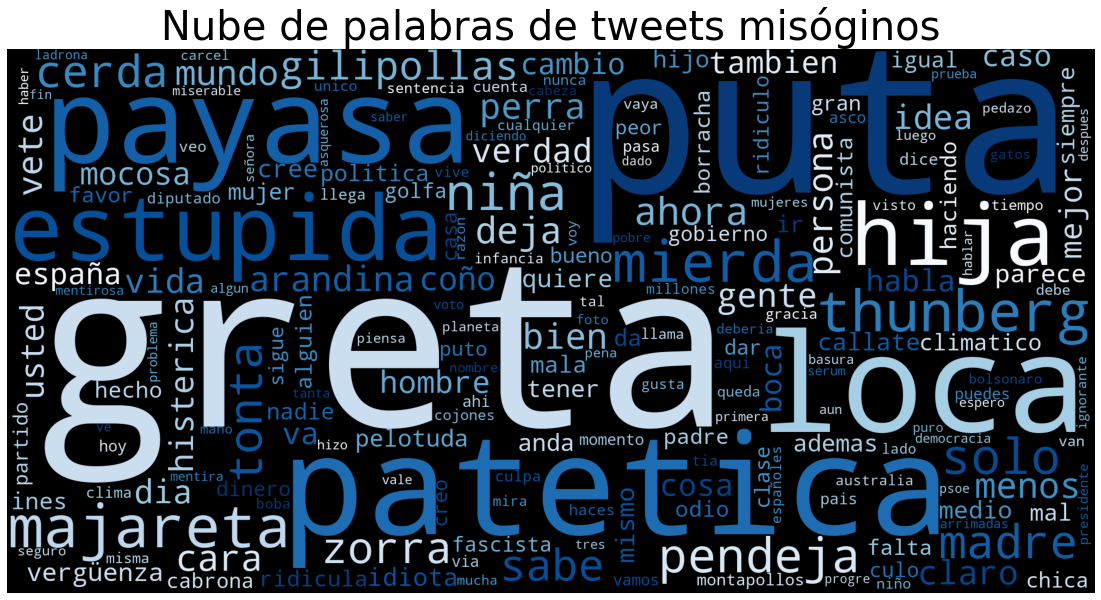

In [32]:
# Generar nube de palabras
# Greys
# RdPu
# Texto_final['Lema_Mayores']
# Texto_final[Texto_final['Tipo']=='misogino'] o 'no_misogino'
metodo = Texto_final[Texto_final['Tipo'] == 'misogino']
plt.figure(figsize = (20,10))
text_nube = metodo.Lema_Mayores.values
cloud1 = WordCloud(background_color = 'black', colormap = 'Blues', collocations = False,
                 width = 2000, height = 1000).generate(' '.join(text_nube))

plt.axis('off')
plt.title('Nube de palabras de tweets misóginos', fontsize = 40)
plt.imshow(cloud1)
plt.savefig('/content/drive/MyDrive/Mini-proyecto Texto/nube1.jpg')

## Frecuencia de palabras

In [33]:
texto_analizar = metodo['Lema_Mayores']
tokenizar = [cadena.split() for cadena in texto_analizar]
descripcion = []
for cadena in tokenizar:
    for i in cadena:
        descripcion.append(i)

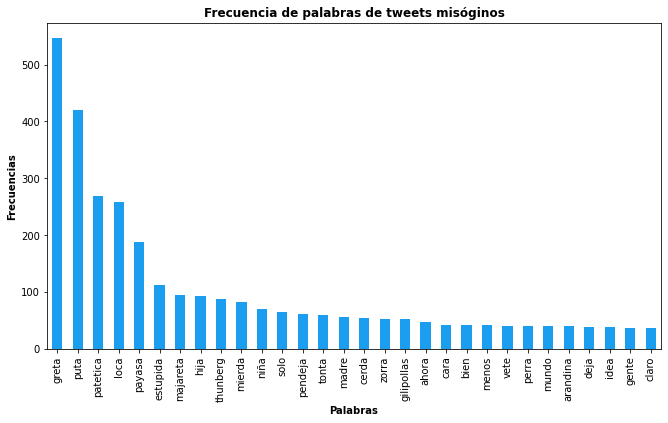

In [34]:
# drimgray
# #1b9df0
def gra_pa(datos, titulo = None):
    aux = pd.Series(datos)
    aux.value_counts()[:30].plot.bar(figsize = (11, 6), color = '#1b9df0')
    if titulo: 
        plt.title(titulo, fontweight = 'bold')
    plt.xlabel('Palabras', fontweight = 'bold')
    plt.ylabel('Frecuencias', fontweight = 'bold')

gra_pa(descripcion, titulo = 'Frecuencia de palabras de tweets misóginos')
plt.savefig('/content/drive/MyDrive/Mini-proyecto Texto/frecu1.jpg')

# Modelo

In [35]:
tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 5, norm = 'l2', encoding = 'latin-1',
                        ngram_range = (1, 2), stop_words = sw)

features = tfidf.fit_transform(Texto_final.Lema_Mayores).toarray()
labels = Texto_final.Categoria_ID
features.shape

(4032, 1815)

In [36]:
N = 3
for Tipo, Categoria_ID in sorted(Categoria_a_ID.items()):
  features_chi2 = chi2(features, labels == Categoria_ID)
  indices = np.argsort(features_chi2[Categoria_ID])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Tipo))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'misogino':
  . Most correlated unigrams:
       . sueldo
       . desastre
       . querido
  . Most correlated bigrams:
       . discurso greta
       . re mil
       . prensa greta
# 'no_misogino':
  . Most correlated unigrams:
       . loca
       . payasa
       . patetica
  . Most correlated bigrams:
       . hija puta
       . greta thunberg
       . greta majareta


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(Texto_final['Lema_Mayores'],
                                                    Texto_final['Tipo'], random_state = 0,
                                                    test_size = 0.35)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [38]:
# Entrenamiento de diferente modelos
Inicio = time()
models = [RandomForestClassifier(n_estimators = 200, max_depth = None, random_state = 0),
          LinearSVC(),
          MultinomialNB(),
          LogisticRegression(random_state = 0)]

CV = 20
cv_df = pd.DataFrame(index = range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring = 'accuracy', cv = CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Final = time()
Tiempo_total = Final - Inicio

print("\nTiempo de entrenamiento: {:.0f}h {:.0f}m {:.0f}s.".format(Tiempo_total // (60 * 60),
                                                                  Tiempo_total // 60,
                                                                  Tiempo_total % 60))


Tiempo de entrenamiento: 0h 2m 47s.


In [39]:
cv_df.to_csv('/content/drive/MyDrive/Mini-proyecto Texto/prueba.csv', header = True, index = False)

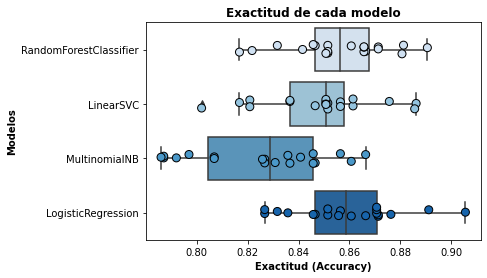

<Figure size 864x504 with 0 Axes>

In [40]:
# Gráfica de caja de todos los modelos
#, hue='model_name'
ax = sns.boxplot(x = 'accuracy', y = 'model_name', data = cv_df, palette = 'Blues')
sns.stripplot(x = 'accuracy', y = 'model_name', data = cv_df, palette = 'Blues',
              size=8, jitter=True, edgecolor = 'black', linewidth=1, dodge=True, ax=ax, ec='k')
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[:4], labels[:4], title='Modelos', bbox_to_anchor=(1, 1.02),
#          loc='upper left')
plt.title('Exactitud de cada modelo', fontweight = 'bold')
plt.xlabel('Exactitud (Accuracy)', fontweight = 'bold')
plt.ylabel('Modelos', fontweight = 'bold')
plt.figure(figsize=(12, 7))
plt.show()

In [41]:
# Promedio de exactitud por modelo
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.848467
LogisticRegression        0.859137
MultinomialNB             0.825414
RandomForestClassifier    0.856417
Name: accuracy, dtype: float64

In [42]:
# Modelo seleccionado
model = LogisticRegression(random_state = 0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels,
                                                                                 Texto_final.index,
                                                                                 test_size = 0.35,
                                                                                 random_state = 0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Reporte

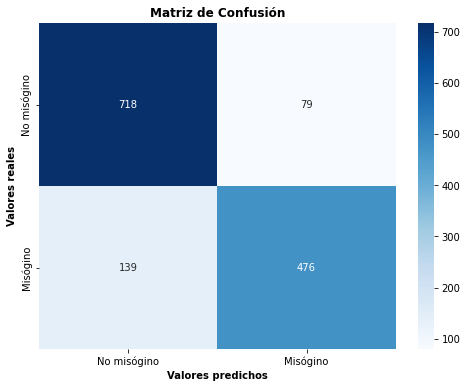

In [43]:
# Matriz de confusión
# PuBu
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(conf_mat, annot = True, fmt = 'd',
            xticklabels = ['No misógino', 'Misógino'],
            yticklabels = ['No misógino', 'Misógino'], cmap = 'Blues',
            linecolor = 'black')
plt.title('Matriz de Confusión', fontweight = 'bold')
plt.xlabel('Valores predichos', fontweight = 'bold')
plt.ylabel('Valores reales', fontweight = 'bold')
plt.show()

In [44]:
# Reporte de clasificación
Etiquetas = ['No misógino', 'Misógino']

print("Reporte de clasificación:")
print(metrics.classification_report(y_test, y_pred, target_names = Etiquetas))

Reporte de clasificación:
              precision    recall  f1-score   support

 No misógino       0.84      0.90      0.87       797
    Misógino       0.86      0.77      0.81       615

    accuracy                           0.85      1412
   macro avg       0.85      0.84      0.84      1412
weighted avg       0.85      0.85      0.84      1412



In [45]:
# Predicción de los tweets
for predicted in Categoria_ID_datos.Categoria_ID:
  for actual in Categoria_ID_datos.Categoria_ID:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(ID_a_Categoria[actual], ID_a_Categoria[predicted], conf_mat[actual, predicted]))
      display(Texto_final.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Tipo', 'Texto']])
      print('')

'misogino' predicted as 'no_misogino' : 139 examples.


,Tipo,Texto
3581,misogino,"Si digo ""creo en el viejito pascuero"" lo menos..."
1897,misogino,"@LaFallaras Calla petarda, que si no fuera por..."
1386,misogino,@IrantzuVarela Doña vividora del conflicto sin...
1256,misogino,El forro hijo de puta de Tinelli me hace acord...
1939,misogino,"q mal me caen la greta y sus padres, dejad q s..."
...,...,...
862,misogino,@GretaThunberg Ves a ayudar gilipollas 🤮🤮🤮
121,misogino,No entiendo la razón de los medios para darle ...
3265,misogino,@24h_tve @GretaThunberg A ver gilipollas de TV...
2491,misogino,"@mirandodenoche @Paeio @N0scucho Buuu claro, a..."



'no_misogino' predicted as 'misogino' : 79 examples.


,Tipo,Texto
935,no_misogino,@LaFallaras Vaya hijosdeputa y por qué a ellos...
3855,no_misogino,Me vuelvo loca por Greta LPM
3870,no_misogino,@Barbijaputa Yo me ponía a cortar cebolla como...
918,no_misogino,@InesArrimadas Sabes contar? Pues no cuentes c...
3803,no_misogino,@monasterioR @InesTorquemada Por qué no se pla...
...,...,...
3025,no_misogino,@LaFallaras Pues verás cuando lleguen los años...
2803,no_misogino,"@LaFallaras La rabia es estupida... ""Lazos de ..."
1355,no_misogino,@AnabelAlonso_of Vete a la PUTA MIERDA PESTOSO...
2329,no_misogino,Mal que me pese aquí Greta dice la puta verdad...


In [46]:
# m
# nom
# m
# nom
# m
texts = ['Greta la majareta nunca ha visitado ni se ha quejado en los paises q más contaminan dl mundo, una marioneta d la extrema izquierda comunista.',
         'Entonces llega el momento en que todo fascista se convierte en hincha del Albacete, sigue todos los partidos de la Arandina y, sobre todo, es un entendido de Ópera, conocedor y admirador del vibrato de Plácido Domingo. De toda la vida. https://t.co/GqmQacy5k3',
         '@monasterioR @julia_otero Tienes mucha pinta tu de agricultora... Tienes mas pinta de cerda que de ganadera.',
         'A mi lo de Greta me parece espectacular. ¿Qué es un monigote? Puede. ¿Qué es un producto de marketing? Quizás. ¿Qué está haciendo que todo el mundo hable de ecologismo por primera vez en la puta historia? Repito: todo el mundo. Totalmente sí.',
         'Respirar también contamina según Greta Thunberg me cago en su vida zorra https://t.co/4Cemt5BARQ']
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(ID_a_Categoria[predicted]))
  print("")

"Greta la majareta nunca ha visitado ni se ha quejado en los paises q más contaminan dl mundo, una marioneta d la extrema izquierda comunista."
  - Predicted as: 'misogino'

"Entonces llega el momento en que todo fascista se convierte en hincha del Albacete, sigue todos los partidos de la Arandina y, sobre todo, es un entendido de Ópera, conocedor y admirador del vibrato de Plácido Domingo. De toda la vida. https://t.co/GqmQacy5k3"
  - Predicted as: 'no_misogino'

"@monasterioR @julia_otero Tienes mucha pinta tu de agricultora... Tienes mas pinta de cerda que de ganadera."
  - Predicted as: 'misogino'

"A mi lo de Greta me parece espectacular. ¿Qué es un monigote? Puede. ¿Qué es un producto de marketing? Quizás. ¿Qué está haciendo que todo el mundo hable de ecologismo por primera vez en la puta historia? Repito: todo el mundo. Totalmente sí."
  - Predicted as: 'no_misogino'

"Respirar también contamina según Greta Thunberg me cago en su vida zorra https://t.co/4Cemt5BARQ"
  - Predicted

In [47]:
#model.fit(features, labels)

#N = 3
#for Tipo, Categoria_ID in sorted(Categoria_a_ID.items()):
#  indices = np.argsort(model.coef_[Categoria_ID])
#  feature_names = np.array(tfidf.get_feature_names())[indices]
#  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
#  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
#  print("# '{}':".format(Tipo))
#  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
#  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))